In [34]:
from quantopian.research import run_pipeline
from quantopian.pipeline import Pipeline
from quantopian.pipeline.factors import Latest, MarketCap
from quantopian.pipeline.data.builtin import USEquityPricing
from quantopian.pipeline.data import Fundamentals
from quantopian.pipeline.factors import MarketCap, CustomFactor, SimpleMovingAverage, AverageDollarVolume, Returns, RSI, BollingerBands
from quantopian.pipeline.classifiers.morningstar import Sector
from quantopian.pipeline.filters import Q500US, Q1500US, Q3000US, QTradableStocksUS, default_us_equity_universe_mask
from quantopian.pipeline.data.quandl import fred_usdontd156n as libor
from quantopian.pipeline.data.zacks import EarningsSurprises
from quantopian.pipeline.data.psychsignal import aggregated_twitter_withretweets_stocktwits as st
import quantopian.optimize as opt

import talib
import pandas as pd
import numpy as np
from time import time

import alphalens as al
import pyfolio as pf
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.hmm import GaussianHMM
from sklearn import linear_model, decomposition, ensemble, preprocessing, isotonic, metrics, svm, neighbors

In [2]:
def get_col_zscore(col):
    #df['zscore'] = (df.a - df.a.mean())/df.a.std(ddof=0)
    return (col - col.mean())/col.std(ddof=0)

In [32]:
#bs = morningstar.balance_sheet
#cfs = morningstar.cash_flow_statement
#is_ = morningstar.income_statement
#or_ = morningstar.operation_ratios
#er = morningstar.earnings_report
#v = morningstar.valuation
#vr = morningstar.valuation_ratios

class Sector(Sector):
    window_safe = True

def Growth_Score():
    return Fundamentals.growth_score.latest
    
def Value_Score():
    return Fundamentals.value_score.latest

def make_factors():
    class Industry(CustomFactor):
        i_code = Fundamentals.morningstar_industry_code.latest
        i_code.window_safe = True
        inputs = [i_code]
        window_length = 1
        def compute(self,today,assets,out,ind):
            out[:] = ind
    
    def Asset_Growth_3M():
        return Returns(inputs=[Fundamentals.total_assets], window_length=63)

    def Asset_To_Equity_Ratio():
        return Fundamentals.total_assets.latest / Fundamentals.common_stock_equity.latest
    
    #def Bollinger_Bands_State():
    #    bb = BollingerBands(window_length=20, k=2)
    #    last_close = USEquityPricing.close.latest
    #    if last_close >= bb.upper:
    #        return 4
    #    elif last_close > bb.middle:
    #        return 3
    #    elif last_close > bb.lower:
    #        return 2
    #    else:
    #        return 1
    
    def Bollinger_Bands_Upper():
        return BollingerBands(window_length=20, k=2).upper
    
    def Bollinger_Bands_Lower():
        return BollingerBands(window_length=20, k=2).lower
    
    def Bollinger_Bands_Middle():
        return BollingerBands(window_length=20, k=2).middle
    
    def Return_On_Total_Equity():
        return Fundamentals.roe.latest
    

    def Capex_To_Cashflows():
        return (Fundamentals.capital_expenditure.latest * 4.) / \
            (Fundamentals.free_cash_flow.latest * 4.)
        
    def Debt_To_Equity_Ratio():
        """
        Is actually LT Debt/Equity
        """
        return Fundamentals.long_term_debt_equity_ratio.latest
    
    def EBITDA_Yield():
        return (Fundamentals.ebitda.latest * 4.) / \
            USEquityPricing.close.latest        

    def EBIT_To_Assets():
        return (Fundamentals.ebit.latest * 4.) / \
            Fundamentals.total_assets.latest
    
    def Earnings_Growth_12M():
        return Returns(inputs=[Fundamentals.diluted_eps_earnings_reports], window_length=252)
    
    def EPS():
        return Fundamentals.normalized_diluted_eps_earnings_reports.latest
    
    def Earnings_Quality():
        return Fundamentals.operating_cash_flow.latest / \
               EarningsSurprises.eps_act.latest
        
    class Earnings_Surprise(CustomFactor):
        esp = EarningsSurprises.eps_pct_diff_surp.latest
        esp.window_safe = True
        shares = Fundamentals.shares_outstanding
        shares.window_safe = True
        inputs = [esp,shares]
        window_length = 1
        def compute(self,today,assets,out,esp,shares):
            out[:] = esp*shares[-1]
    
    def Leverage():
        return Fundamentals.financial_leverage.latest
    
    def Op_Revenue_Growth():
        return Fundamentals.operation_revenue_growth3_month_avg.latest
    
    def Price_To_Forward_Earnings():
        return Fundamentals.forward_pe_ratio.latest
    
    def Price_To_Earnings():
        return Fundamentals.pe_ratio.latest
    
    def Price_To_Book():
        return USEquityPricing.close.latest / \
            Fundamentals.book_value_per_share.latest
    
    def Price_To_Sales():
        return Fundamentals.ps_ratio.latest
    
    def Profit_Margin():
        return Fundamentals.normalized_net_profit_margin.latest
    
    def Return_On_Total_Invest_Capital():
        return Fundamentals.roic.latest
    
    class Mean_Reversion_1M(CustomFactor):
        inputs = [Returns(window_length=21)]
        window_length = 252

        def compute(self, today, assets, out, monthly_rets):
            out[:] = (monthly_rets[-1] - np.nanmean(monthly_rets, axis=0)) / \
                np.nanstd(monthly_rets, axis=0)
                
    class MACD_Signal_10d(CustomFactor):
        inputs = [USEquityPricing.close]
        window_length = 60

        def compute(self, today, assets, out, close):

            sig_lines = []

            for col in close.T:
                # get signal line only
                try:
                    _, signal_line, _ = talib.MACD(col, fastperiod=12,
                                                   slowperiod=26, signalperiod=10)
                    sig_lines.append(signal_line[-1])
                # if error calculating, return NaN
                except:
                    sig_lines.append(np.nan)
            out[:] = sig_lines 
            
    class Moneyflow_Volume_5d(CustomFactor):
        inputs = [USEquityPricing.close, USEquityPricing.volume]
        window_length = 5

        def compute(self, today, assets, out, close, volume):

            mfvs = []

            for col_c, col_v in zip(close.T, volume.T):

                # denominator
                denominator = np.dot(col_c, col_v)

                # numerator
                numerator = 0.
                for n, price in enumerate(col_c.tolist()):
                    if price > col_c[n - 1]:
                        numerator += price * col_v[n]
                    else:
                        numerator -= price * col_v[n]

                mfvs.append(numerator / denominator)
            out[:] = mfvs  
            
           
    def Net_Income_Margin():
        return Fundamentals.net_margin.latest           

    def Operating_Cashflows_To_Assets():
        return (Fundamentals.operating_cash_flow.latest * 4.) / \
            Fundamentals.total_assets.latest
    
    def Last_Price():
        return USEquityPricing.close.latest
    
    def Price_Momentum_3M():
        return Returns(window_length=63)
    
    def Price_Momentum_1M():
        return Returns(window_length=21)
    
    class Price_Oscillator(CustomFactor):
        inputs = [USEquityPricing.close]
        window_length = 252

        def compute(self, today, assets, out, close):
            four_week_period = close[-20:]
            out[:] = (np.nanmean(four_week_period, axis=0) /
                      np.nanmean(close, axis=0)) - 1.
    
    def Returns_39W():
        return Returns(window_length=215)
    
    def RSI_factor():
        return RSI(window_length=5)
    
    class Trader_Mood(CustomFactor):
        inputs = [st.bull_scored_messages, st.bear_scored_messages, st.total_scanned_messages]
        window_length = 21
        def compute(self, today, assets, out, bull, bear, total):
            out[:] = np.nansum(bull, axis=0)/np.nansum(total,axis=0)

    class Trendline(CustomFactor):
        inputs = [USEquityPricing.close]
        window_length = 252

        # using MLE for speed
        def compute(self, today, assets, out, close):

            # prepare X matrix (x_is - x_bar)
            X = range(self.window_length)
            X_bar = np.nanmean(X)
            X_vector = X - X_bar
            X_matrix = np.tile(X_vector, (len(close.T), 1)).T

            # prepare Y matrix (y_is - y_bar)
            Y_bar = np.nanmean(close, axis=0)
            Y_bars = np.tile(Y_bar, (self.window_length, 1))
            Y_matrix = close - Y_bars

            # prepare variance of X
            X_var = np.nanvar(X)

            # multiply X matrix an Y matrix and sum (dot product)
            # then divide by variance of X
            # this gives the MLE of Beta
            out[:] = (np.sum((X_matrix * Y_matrix), axis=0) / X_var) / \
                (self.window_length)
                
    class Volume_Trendline(CustomFactor):
        daily_dollar_volume = AverageDollarVolume(window_length=1)
        inputs = [daily_dollar_volume]
        window_length = 252

        # using MLE for speed
        def compute(self, today, assets, out, close):

            # prepare X matrix (x_is - x_bar)
            X = range(self.window_length)
            X_bar = np.nanmean(X)
            X_vector = X - X_bar
            X_matrix = np.tile(X_vector, (len(close.T), 1)).T

            # prepare Y matrix (y_is - y_bar)
            Y_bar = np.nanmean(close, axis=0)
            Y_bars = np.tile(Y_bar, (self.window_length, 1))
            Y_matrix = close - Y_bars

            # prepare variance of X
            X_var = np.nanvar(X)

            # multiply X matrix an Y matrix and sum (dot product)
            # then divide by variance of X
            # this gives the MLE of Beta
            out[:] = (np.sum((X_matrix * Y_matrix), axis=0) / X_var) / \
                (self.window_length)
    
    class Vol_3M(CustomFactor):
        inputs = [Returns(window_length=2)]
        window_length = 63

        def compute(self, today, assets, out, rets):
            out[:] = np.nanstd(rets, axis=0)
            
    def Working_Capital_To_Assets():
        return Fundamentals.working_capital.latest / Fundamentals.total_assets.latest
    
    class Stochastic_Oscillator(CustomFactor):
        """
        20-day Stochastic Oscillator:
        K = (close price - 5-day low) / (5-day high - 5-day low)
        D = 100 * (average of past 3 K's)
        We use the slow-D period here (the D above)
        https://www.math.nyu.edu/faculty/avellane/Lo13030.pdf
        Notes:
        High value suggests turning point in positive momentum (expected decrease)
        Low value suggests turning point in negative momentum (expected increase)
        """
        inputs = [USEquityPricing.close,
                  USEquityPricing.high, USEquityPricing.low]
        window_length = 30

        def compute(self, today, assets, out, close, high, low):

            stoch_list = []

            for col_c, col_h, col_l in zip(close.T, high.T, low.T):
                try:
                    _, slowd = talib.STOCH(col_h, col_l, col_c,
                                           fastk_period=5, slowk_period=3, slowk_matype=0,
                                           slowd_period=3, slowd_matype=0)
                    stoch_list.append(slowd[-1])
                # if error calculating
                except:
                    stoch_list.append(np.nan)

            out[:] = stoch_list
    
    class Volatility_65(CustomFactor):  
        inputs = [Returns(window_length=2)]  
        window_length = 65
        def compute(self, today, assets, out, close):  
            # [0:-1] is needed to remove last close since diff is one element shorter  
            daily_returns = np.diff(close, axis = 0) / close[0:-1]  
            out[:] = daily_returns.std(axis = 0)
    
    class Volatility_20(CustomFactor):  
        inputs = [Returns(window_length=2)]  
        window_length = 20
        def compute(self, today, assets, out, close):  
            # [0:-1] is needed to remove last close since diff is one element shorter  
            daily_returns = np.diff(close, axis = 0) / close[0:-1]  
            out[:] = daily_returns.std(axis = 0)
    
    class Volatility_10(CustomFactor):  
        inputs = [Returns(window_length=2)]  
        window_length = 10
        def compute(self, today, assets, out, close):  
            # [0:-1] is needed to remove last close since diff is one element shorter  
            daily_returns = np.diff(close, axis = 0) / close[0:-1]  
            out[:] = daily_returns.std(axis = 0)
    
    class Volatility_5(CustomFactor):  
        inputs = [Returns(window_length=2)]  
        window_length = 5
        def compute(self, today, assets, out, close):  
            # [0:-1] is needed to remove last close since diff is one element shorter  
            daily_returns = np.diff(close, axis = 0) / close[0:-1]  
            out[:] = daily_returns.std(axis = 0)

    all_factors = {
        #'Industry': Industry,
        'Asset Growth 3M': Asset_Growth_3M,
        'Asset to Equity Ratio': Asset_To_Equity_Ratio,
        #'BB Upper': Bollinger_Bands_Upper,
        #'BB Middle': Bollinger_Bands_Middle,
        #'BB Lower': Bollinger_Bands_Lower,
        'Return on Equity': Return_On_Total_Equity,
        #'Capex to Cashflows': Capex_To_Cashflows,
        'Debt to Equity Ratio': Debt_To_Equity_Ratio,
        #'EBIT to Assets': EBIT_To_Assets,
        #'EBITDA Yield': EBITDA_Yield,
        'Earnings Growth': Earnings_Growth_12M,
        'Operating Revenue Growth': Op_Revenue_Growth,
        'Earnings Per Share': EPS,
        #'Earnings Quality': Earnings_Quality,
        #'Earnings Surprise': Earnings_Surprise,
        #'Growth Score': Growth_Score,
        'Leverage': Leverage,
        'Price to Forward Earnings': Price_To_Forward_Earnings,
        'Price to Earnings': Price_To_Earnings,
        #'Price to Book': Price_To_Book,
        'Price to Sales': Price_To_Sales,
        'Profit Margin': Profit_Margin,
        #'RSI': RSI_factor,
        #'MACD Signal Line': MACD_Signal_10d,
        #'Mean Reversion 1M': Mean_Reversion_1M,
        #'Moneyflow Volume 5D': Moneyflow_Volume_5d,
        'Net Income Margin': Net_Income_Margin,        
        'Operating Cashflows to Assets': Operating_Cashflows_To_Assets,
        'Momentum 1M': Price_Momentum_1M,
        #'Price' : Last_Price,
        #'Price Momentum 3M': Price_Momentum_3M,
        #'Price Oscillator': Price_Oscillator,
        'Return on Invest Capital': Return_On_Total_Invest_Capital,
        #'Stochastic Oscillator': Stochastic_Oscillator,
        #'39 Week Returns': Returns_39W,
        #'Trader Mood': Trader_Mood,
        'Trendline': Trendline,
        #'Volume Trendline': Volume_Trendline,
        #'Value Score': Value_Score,
        'Vol 3M': Vol_3M,
        #'Volatility 5': Volatility_5,
        'Volatility 10': Volatility_10,
        'Volatility 20': Volatility_20,
        'Volatility 65': Volatility_65,
        'Market Cap': MarketCap,
        #'Working Capital to Assets': Working_Capital_To_Assets,
        #'Volatility': Volatility,
    }
    
    return all_factors

In [38]:
default_us_equity_universe_mask(minimum_market_cap=100000000)
#universe = Q3000US()
universe = QTradableStocksUS()

factors = make_factors()

In [39]:
n_fwd_days = 65 # number of days to compute returns over

In [6]:
def shift_mask_data(X, Y, upper_percentile=80, lower_percentile=20, n_fwd_days=1):
    # Shift X to match factors at t to returns at t+n_fwd_days (we want to predict future returns after all)
    shifted_X = np.roll(X, n_fwd_days, axis=0)
    
    # Slice off rolled elements
    X = shifted_X[n_fwd_days:]
    Y = Y[n_fwd_days:]
    
    print(X)
    print(Y)
    
    n_time, n_stocks, n_factors = X.shape
    
    # Look for biggest up and down movers
    upper = np.nanpercentile(Y, upper_percentile, axis=1)[:, np.newaxis]
    lower = np.nanpercentile(Y, lower_percentile, axis=1)[:, np.newaxis]
  
    upper_mask = (Y >= upper)
    lower_mask = (Y <= lower)
    
    mask = upper_mask | lower_mask # This also drops nans
    mask = mask.flatten()
    
    # Only try to predict whether a stock moved up/down relative to other stocks
    Y_binary = np.zeros(n_time * n_stocks)
    Y_binary[upper_mask.flatten()] = 1
    Y_binary[lower_mask.flatten()] = -1
    
    # Flatten X
    X = X.reshape((n_time * n_stocks, n_factors))

    # Drop stocks that did not move much (i.e. are in the 30th to 70th percentile)
    X = X[mask]
    Y_binary = Y_binary[mask]
    
    return X, Y_binary

def timeshift(df,n):
    replacements = {i1:i2 for i1, i2 in zip(df.index.levels[0],df.index.levels[0].shift(n,freq='D'))}
    return df.rename(replacements)

def get_last_values(input_data):
    last_values = []
    for dataset in input_data:
        last_values.append(dataset[-1])
    return np.vstack(last_values).T

def postprocess(x):
        return (x-0.5)*2

In [40]:
from collections import OrderedDict

def ml_inputs_pipeline(factors, universe, n_fwd_days=65):#, window_length=756):
    factors_pipe = OrderedDict()
    # Create returns over last n days.
    #factors_pipe['Returns'] = Returns(inputs=[USEquityPricing.open],
    #                                  mask=universe, window_length=n_fwd_days)
    # Instantiate ranked factors
    for name, f in factors.items():
        #factors_pipe[name] = f().zscore(mask=universe,groupby=Sector())#.rank(mask=universe)
        factors_pipe[name] = f()#zscore(mask=universe)#.rank(mask=universe)
    
    factors_pipe['Sector'] = Sector()
    
    factors_pipe['Growth Score'] = Growth_Score()
    factors_pipe['Value Score'] = Value_Score()
    
    for col in pipeline_columns:
        pipeline_columns[col].window_safe = True
    
    # Create our ML pipeline factor. The window_length will control how much
    # lookback the passed in data will have.
    #factors_pipe['ML'] = ML(inputs=factors_pipe.values(), 
    #                        window_length=window_length + 1, 
    #                        mask=universe)
    
    #factors_pipe['ML'].set_training_var()
    
    pipe = Pipeline(screen=universe, columns=factors_pipe)
    
    return pipe

In [41]:
features_pipe = ml_inputs_pipeline(factors, universe)

In [42]:
start_timer = time()
start = pd.Timestamp("2017-01-01")
end = pd.Timestamp("2019-04-01")
#start = pd.Timestamp("2020-01-21")
#end = pd.Timestamp("2020-01-21")

training_set = run_pipeline(features_pipe, start_date=start, end_date=end, chunksize=65)

end_timer = time()

In [43]:
print "Time to run pipeline %.2f secs" % (end_timer - start_timer)

Time to run pipeline 141.69 secs


In [13]:
n_fwd_days=65

In [14]:
training_set.index.levels[0].values[0]

numpy.datetime64('2017-01-03T00:00:00.000000000')

In [46]:
print(training_set.columns.values)
print(training_set.isnull().all(axis=0))

['Asset Growth 3M' 'Asset to Equity Ratio' 'Debt to Equity Ratio'
 'Earnings Growth' 'Earnings Per Share' 'Growth Score' 'Leverage'
 'Market Cap' 'Momentum 1M' 'Net Income Margin'
 'Operating Cashflows to Assets' 'Operating Revenue Growth'
 'Price to Earnings' 'Price to Forward Earnings' 'Price to Sales'
 'Profit Margin' 'Return on Equity' 'Return on Invest Capital' 'Sector'
 'Trendline' 'Value Score' 'Vol 3M' 'Volatility 10' 'Volatility 20'
 'Volatility 65']
Asset Growth 3M                  False
Asset to Equity Ratio            False
Debt to Equity Ratio             False
Earnings Growth                  False
Earnings Per Share               False
Growth Score                     False
Leverage                         False
Market Cap                       False
Momentum 1M                      False
Net Income Margin                False
Operating Cashflows to Assets    False
Operating Revenue Growth         False
Price to Earnings                False
Price to Forward Earnings    

In [37]:
training_returns_pipe = Pipeline(screen=universe,columns={'Returns': Returns(window_length=n_fwd_days)})
n_day_returns = run_pipeline(training_returns_pipe, start_date=training_set.index.levels[0].values[0] + pd.Timedelta(days=n_fwd_days), end_date=training_set.index.levels[0].values[-1] + pd.Timedelta(days=n_fwd_days))

In [71]:
#training_set_no_nan = training_set.dropna()
shifted_returns = timeshift(n_day_returns, -n_fwd_days)
set_with_returns = pd.concat([training_set,shifted_returns.loc[training_set.index.values]],axis=1).dropna()
print set_with_returns.shape
#print(set_with_returns.columns)
#print(set_with_returns.stack())

(315286, 26)


In [17]:
#print(shifted_returns['Returns'])
#shifted_returns.head(-1)
#print(set_with_returns.dtype)

In [48]:
start_timer = time()
#start = pd.Timestamp("2015-01-01")
#end = pd.Timestamp("2019-02-01")
start_2 = pd.Timestamp("2020-01-21")
end_2 = pd.Timestamp("2020-01-21")

test_set = run_pipeline(ml_inputs_pipeline(factors, universe), start_date=start_2, end_date=end_2)

end_timer = time()

In [19]:
#test_set = test_set.dropna()

In [77]:
#print set_with_returns['Asset to Equity Ratio']
print(set_with_returns.isnull().any())

2017-01-03 00:00:00+00:00  Equity(2 [ARNC])         3.196040
                           Equity(24 [AAPL])        2.508292
                           Equity(31 [ABAX])        1.139503
                           Equity(41 [ARCB])        2.219376
                           Equity(52 [ABM])         2.342094
                           Equity(64 [GOLD])        3.408885
                           Equity(67 [ADSK])        4.553272
                           Equity(76 [TAP])         2.237693
                           Equity(114 [ADBE])       1.699304
                           Equity(122 [ADI])        1.542948
                           Equity(128 [ADM])        2.272380
                           Equity(154 [AEM])        1.608823
                           Equity(161 [AEP])        3.547070
                           Equity(166 [AES])       12.875781
                           Equity(168 [AET])        3.931513
                           Equity(185 [AFL])        6.324380
                        

In [73]:
class Regressor():
    def __init__(self):
        self._imputer = preprocessing.Imputer(missing_values=np.nan, strategy='mean', axis=0, verbose = True)
        self._scaler = preprocessing.MinMaxScaler()
        self._classifier = linear_model.SGDRegressor(penalty='elasticnet',loss='huber',n_iter=5)
    
    def _preprocess_stonks(self, data, returns, predict='Returns'):
        #data_no_nans = data.dropna()
        #X = np.dstack(data_no_nans.drop(predict, axis=1))
        #X = data_no_nans.drop([predict], axis=1)
        #print data
        X = data.drop(predict, axis=1).values
        X = np.dstack(X)
        #print(X.shape)
        a,b,c = X.shape
        self.X = X.reshape((a * b, c))
        #self.X = X.stack(level=0).reshape((a, b))
        #self.X = X
        #self.Y = data_no_nans[predict]
        self.Y = data[predict].values
    
    def preprocess_stonks(self, data, predict='Returns'):
        #data_no_nans = data.dropna()
        #X = np.dstack(data_no_nans.drop(predict, axis=1))
        #X = data_no_nans.drop([predict], axis=1)
        features=data.astype('float64')
        print features.shape
        print features.columns.values
        #print features[predict]
        imputer = self._imputer
        scaler = self._scaler
        X = features.drop(predict,axis=1)
        #print(X.shape)
        #print(X.columns.values)
        X = pd.DataFrame(imputer.fit_transform(X))
        print(X.shape)
        Y = pd.DataFrame(imputer.fit_transform(features[predict]))
        
        self.X = scaler.fit_transform(X)
        self.Y = np.ravel(Y)
    
    def train(self, **kwargs):
        start = time()
        print("Traning model")
        X = kwargs.get('X', self.X)
        Y = kwargs.get('Y', self.Y)
        classifier = self._classifier
        #print(X.shape)
        #print(Y.shape)
        self.classifier = self._classifier.fit(X,Y)
        print("Trained in: "+ str(time()-start))
    
    def predict(self, X):
        #X = np.dstack(X.drop(predict, axis=1))
        #X = X.dropna()#.stack().values
        #n_time, n_stocks, n_factors = X.shape
        imputer = self._imputer
        scaler = self._scaler
        #dates = X.index.get_level_values(0)
        #last_date = dates[-1:]
        #idx = pd.IndexSlice
        #X = X.loc[idx[last_date:, :], :]
        #X = X.reshape((n_time*n_stocks, n_factors))
        #print(X)
        #X = X.dropna()
        
        #X = X.drop([''])
        
        last_date = X.index.levels[0][-1]
        X = X.loc[last_date, :]
        securities = X.index.values
        X = np.dstack(X)
        #print(X.shape)
        a,b,c = X.shape
        self.X = X.reshape((a * b, c))
        X = pd.DataFrame(imputer.fit_transform(X))
        #X = loc(axis=1)[self.X.columns]
        ##print(X.columns)
        ##securities = X.index
        #print(X)
        #print(X.shape)
        #a, b, c = X.shape
        #X = X.reshape((a * b, c))
        X = scaler.fit_transform(X)
        raw_predictions = self.classifier.predict(X)
        predictions = pd.DataFrame(data=raw_predictions,index=securities,columns=['Projection'])
        
        return predictions

In [82]:
class Regressor():
    def __init__(self):
        self._imputer = preprocessing.Imputer(missing_values='NaN', strategy='mean', axis=0, verbose = True)
        self._scaler = preprocessing.MinMaxScaler()
        self._classifier = linear_model.SGDRegressor(penalty='elasticnet',loss='huber',n_iter=5)
    
    def _preprocess_stonks(self, data, returns, predict='Returns'):
        #data_no_nans = data.dropna()
        #X = np.dstack(data_no_nans.drop(predict, axis=1))
        #X = data_no_nans.drop([predict], axis=1)
        #print data
        X = data.drop(predict, axis=1).values
        #X = np.dstack(X)
        X = np.ndarray(X.values)
        #print(X.shape)
        #a,b,c = X.shape
        #self.X = X.reshape((a * b, c))
        #self.X = X.stack(level=0).reshape((a, b))
        #self.X = X
        #self.Y = data_no_nans[predict]
        self.Y = data[predict].values
    
    def preprocess_stonks(self, data, predict='Returns', drop=1):
        #data_no_nans = data.dropna()
        #X = np.dstack(data_no_nans.drop(predict, axis=1))
        #X = data_no_nans.drop([predict], axis=1)
        print(data.isnull().any())
        print(data['Asset to Equity Ratio'])
        features=data.astype('float64')
        #print features.columns.values
        #print features[predict]
        imputer = self._imputer
        scaler = self._scaler
        print(features.isnull().any())
        print(features.shape)
        X = features.drop(predict,axis=1)
        print(X.isnull().all(axis=0))
        
        #print(X)
        #print(X.columns.values)
        #X = np.array(X.values)
        X = imputer.fit_transform(X)
        print(X.shape)
        #X = pd.DataFrame(imputer.fit_transform(X))
        
        #Y = pd.DataFrame(imputer.fit_transform(features[predict]))
        Y = imputer.fit_transform(features[predict].values)
        
        self.X = scaler.fit_transform(X)
        self.Y = np.ravel(Y)
    
    def train(self, **kwargs):
        start = time()
        print("Traning model")
        X = kwargs.get('X', self.X)
        Y = kwargs.get('Y', self.Y)
        classifier = self._classifier
        #print(X.shape)
        #print(Y.shape)
        self.classifier = self._classifier.fit(X,Y)
        print("Trained in: "+ str(time()-start))
    
    def predict(self, X):
        #X = np.dstack(X.drop(predict, axis=1))
        #X = X.dropna()#.stack().values
        #n_time, n_stocks, n_factors = X.shape
        imputer = self._imputer
        scaler = self._scaler
        #dates = X.index.get_level_values(0)
        #last_date = dates[-1:]
        #idx = pd.IndexSlice
        #X = X.loc[idx[last_date:, :], :]
        #X = X.reshape((n_time*n_stocks, n_factors))
        #print(X)
        #X = X.dropna()
        
        #X = X.drop([''])
        
        last_date = X.index.levels[0][-1]
        X = X.loc[last_date, :]
        securities = X.index.values
        #X = np.dstack(X)
        #print(X.shape)
        #a,b,c = X.shape
        #self.X = X.reshape((a * b, c))
        #X = np.array(X.values)
        X = imputer.fit_transform(X)
        #X = loc(axis=1)[self.X.columns]
        ##print(X.columns)
        ##securities = X.index
        #print(X)
        print(X.shape)
        X = scaler.fit_transform(X)
        raw_predictions = self.classifier.predict(X)
        predictions = pd.DataFrame(data=raw_predictions,index=securities,columns=['Projection'])
        
        return predictions

In [83]:
print(set_with_returns.columns.values)

['Asset Growth 3M' 'Asset to Equity Ratio' 'Debt to Equity Ratio'
 'Earnings Growth' 'Earnings Per Share' 'Growth Score' 'Leverage'
 'Market Cap' 'Momentum 1M' 'Net Income Margin'
 'Operating Cashflows to Assets' 'Operating Revenue Growth'
 'Price to Earnings' 'Price to Forward Earnings' 'Price to Sales'
 'Profit Margin' 'Return on Equity' 'Return on Invest Capital' 'Sector'
 'Trendline' 'Value Score' 'Vol 3M' 'Volatility 10' 'Volatility 20'
 'Volatility 65' 'Returns']


In [84]:
my_regressor = Regressor()
#print(set_with_returns.columns.values)
my_regressor.preprocess_stonks(set_with_returns)
my_regressor.train()
#predictions = my_regressor.predict(test_set)

Asset Growth 3M                  False
Asset to Equity Ratio            False
Debt to Equity Ratio             False
Earnings Growth                  False
Earnings Per Share               False
Growth Score                     False
Leverage                         False
Market Cap                       False
Momentum 1M                      False
Net Income Margin                False
Operating Cashflows to Assets    False
Operating Revenue Growth         False
Price to Earnings                False
Price to Forward Earnings        False
Price to Sales                   False
Profit Margin                    False
Return on Equity                 False
Return on Invest Capital         False
Sector                           False
Trendline                        False
Value Score                      False
Vol 3M                           False
Volatility 10                    False
Volatility 20                    False
Volatility 65                    False
Returns                  

In [81]:
dropped = [test_set.columns.values[1],test_set.columns.values[3],test_set.columns.values[12]]#,test_set.columns.values[12]]
#print dropped
print(test_set.shape)
#test = test_set.dropna(axis=1, how='all')
test = test_set#.drop(dropped,axis=1)
print test.columns.values

(2066, 25)
['Asset Growth 3M' 'Asset to Equity Ratio' 'Debt to Equity Ratio'
 'Earnings Growth' 'Earnings Per Share' 'Growth Score' 'Leverage'
 'Market Cap' 'Momentum 1M' 'Net Income Margin'
 'Operating Cashflows to Assets' 'Operating Revenue Growth'
 'Price to Earnings' 'Price to Forward Earnings' 'Price to Sales'
 'Profit Margin' 'Return on Equity' 'Return on Invest Capital' 'Sector'
 'Trendline' 'Value Score' 'Vol 3M' 'Volatility 10' 'Volatility 20'
 'Volatility 65']


In [35]:
print test_set.columns.values

['Asset Growth 3M' 'Asset to Equity Ratio' 'Debt to Equity Ratio'
 'Earnings Growth' 'Earnings Per Share' 'Growth Score' 'Leverage'
 'Market Cap' 'Momentum 1M' 'Net Income Margin'
 'Operating Cashflows to Assets' 'Operating Revenue Growth' 'Price to Book'
 'Price to Earnings' 'Price to Forward Earnings' 'Price to Sales'
 'Profit Margin' 'Return on Equity' 'Return on Invest Capital' 'Sector'
 'Trendline' 'Value Score' 'Vol 3M' 'Volatility 10' 'Volatility 20'
 'Volatility 65']


In [23]:
predictions = my_regressor.predict(test)

(2066, 23)


In [24]:
res=predictions['Projection'].sort_values(axis=0, ascending=False)
print(res)

Equity(46053 [ITCI])    0.509742
Equity(13798 [BLDP])    0.404502
Equity(26381 [MNTA])    0.346177
Equity(51245 [SPCE])    0.331449
Equity(49100 [EVH])     0.293794
Equity(45006 [TLRA])    0.282149
Equity(52230 [PRVB])    0.275683
Equity(6330 [RAD])      0.275139
Equity(51271 [MAXR])    0.274633
Equity(53116 [BYND])    0.272491
Equity(20776 [PLUG])    0.271777
Equity(13984 [TGTX])    0.270517
Equity(46315 [RVNC])    0.265365
Equity(46671 [RUBI])    0.261194
Equity(50399 [IRTC])    0.261125
Equity(51423 [APLS])    0.257892
Equity(47955 [CRBP])    0.255868
Equity(44830 [EPZM])    0.240301
Equity(51753 [CDLX])    0.236963
Equity(39840 [TSLA])    0.230841
Equity(29083 [CYRX])    0.224943
Equity(448 [APA])       0.224364
Equity(49608 [MTCH])    0.221637
Equity(51806 [CRON])    0.220895
Equity(4982 [TELL])     0.219932
Equity(50735 [AYX])     0.219926
Equity(45867 [EROS])    0.219000
Equity(46285 [RARE])    0.217831
Equity(51832 [ZS])      0.215968
Equity(50449 [INSG])    0.214805
          

In [25]:
print predictions.columns.values

['Projection']


In [26]:
n_day_return_mean = n_day_returns['Returns'].mean()
n_day_return_median = n_day_returns['Returns'].median()
n_day_return_std = n_day_returns['Returns'].std(ddof=-1)
print(n_day_returns['Returns'].max())
print(n_day_return_mean)
print(n_day_return_std)

5.12962962963
0.0270337982683
0.18556125979


In [27]:
#print(list(results['ML']))
#res = results['ML']['2019-01-16'].sort_values(axis=0, ascending=False)
#res = results['ML'][end].sort_values(axis=0, ascending=False) 
zscores = get_col_zscore(res)
ratings = n_day_return_mean + n_day_return_std*zscores
#ratings = (res-0.5)*2
#ratings = get_col_zscore(res)

In [28]:
zscores = get_col_zscore(res)

In [33]:
watchlist = ['ABBV',
             'AJRD',
             #'AMPH',
             'ARGO',
             'BE',
             'BLDP',
             'BPOP',
             'CYRX',
             'DDD',
             'ENB',
             'EVH',
             'FTCH',
             'GLUU',
             'HASI',
             'IOSP',
             'IRTC',
             'ITCI',
             'MAXR',
             'MNTA',
             'MRK',
             'NSIT',
             'OHI',
             #'OTTR',
             'PLUG',
             'RAD',
             'RCII',
             'RUBI',
             'RVNC',
             'SHEN',
             'SIG',
             'SWKS',
             'WAL',
             #'YTEN'
             'BA',
             'UTX',
             #'QQQ',
             #'SPY'
]

for ticker in watchlist:
    print(ticker+": "+str(res.get_value(symbols(ticker)))+"  |  zscore: "+str(zscores.get_value(symbols(ticker)))+" | rel to last mkt return: "+str(ratings.get_value(symbols(ticker))))#+abs(res.quantile(0.5)))

ABBV: 0.0666927149864  |  zscore: -0.80906467895 | rel to last mkt return: -0.123097262809
AJRD: 0.154628738731  |  zscore: 1.25455178035 | rel to last mkt return: 0.259830007102
ARGO: 0.102842179368  |  zscore: 0.0392637593402 | rel to last mkt return: 0.0343196309155
BE: 0.209883210912  |  zscore: 2.55122217079 | rel to last mkt return: 0.500441798284
BLDP: 0.404501692202  |  zscore: 7.11838229667 | rel to last mkt return: 1.3479297849
BPOP: 0.0971978661445  |  zscore: -0.0931927377065 | rel to last mkt return: 0.00974083645621
CYRX: 0.224942705004  |  zscore: 2.90462705033 | rel to last mkt return: 0.566020052946
DDD: 0.186352316906  |  zscore: 1.99901685032 | rel to last mkt return: 0.397973883355
ENB: 0.104316610271  |  zscore: 0.0738645946912 | rel to last mkt return: 0.0407402055131
EVH: 0.293793843283  |  zscore: 4.52037377325 | rel to last mkt return: 0.865840050353
FTCH: 0.209396692854  |  zscore: 2.53980493097 | rel to last mkt return: 0.49832320088
GLUU: 0.11408480681  |  z

In [164]:
#print(list(res.columns.values))
#print(results['ML'])
#print(res)
#for foo, bar in zscores.head(100).iteritems():
#    print str(foo)+ " " + str(bar)
print(zscores.head(50))
#results['ML'].head(10)
#print(res.tail(100))

Equity(46053 [ITCI])    9.532542
Equity(13798 [BLDP])    7.122138
Equity(26381 [MNTA])    5.718591
Equity(51245 [SPCE])    5.419802
Equity(49100 [EVH])     4.504741
Equity(45006 [TLRA])    4.265754
Equity(51271 [MAXR])    4.096405
Equity(52230 [PRVB])    4.077224
Equity(6330 [RAD])      4.068556
Equity(20776 [PLUG])    4.022601
Equity(53116 [BYND])    4.003096
Equity(13984 [TGTX])    3.941157
Equity(46315 [RVNC])    3.829612
Equity(46671 [RUBI])    3.774352
Equity(50399 [IRTC])    3.736678
Equity(51423 [APLS])    3.661348
Equity(47955 [CRBP])    3.608067
Equity(44830 [EPZM])    3.245451
Equity(51753 [CDLX])    3.214060
Equity(39840 [TSLA])    2.992971
Equity(448 [APA])       2.920478
Equity(49608 [MTCH])    2.852625
Equity(29083 [CYRX])    2.852257
Equity(50735 [AYX])     2.810851
Equity(4982 [TELL])     2.808856
Equity(51806 [CRON])    2.797386
Equity(45867 [EROS])    2.793545
Equity(46285 [RARE])    2.725514
Equity(51832 [ZS])      2.720346
Equity(50449 [INSG])    2.691089
Equity(509

In [165]:
#print(list(res.columns.values))
#print(results['ML'])
#print(res)
print(zscores.tail(50))
#print(zscores.head(-100))
#for foo, bar in ratings.head(-100).iteritems():
#    print str(foo)+ " " + str(bar)
#results['ML'].head(10)
#print(res.tail(100))

Equity(48073 [CRC])    -1.848292
Equity(410 [AN])       -1.855671
Equity(23021 [ECA])    -1.880934
Equity(46027 [AMC])    -1.908865
Equity(19672 [AXL])    -1.928427
Equity(14164 [SWM])    -1.929821
Equity(4751 [MDP])     -1.951480
Equity(35359 [DAN])    -1.955013
Equity(474 [APOG])     -1.960441
Equity(52812 [HEXO])   -1.966186
Equity(50357 [ARCH])   -2.012966
Equity(1374 [CDE])     -2.029589
Equity(19693 [ETM])    -2.040237
Equity(51199 [KRYS])   -2.051640
Equity(52084 [VNE])    -2.055458
Equity(2587 [EQT])     -2.066108
Equity(4901 [MLHR])    -2.156979
Equity(42166 [CLVS])   -2.177901
Equity(39612 [SIX])    -2.178001
Equity(8233 [WNC])     -2.196354
Equity(5824 [TPC])     -2.208146
Equity(19249 [RRC])    -2.243304
Equity(32866 [SBH])    -2.246587
Equity(15789 [DNR])    -2.258546
Equity(52244 [BRY])    -2.273538
Equity(42263 [LPI])    -2.287066
Equity(24094 [MGPI])   -2.290763
Equity(3131 [GCO])     -2.290875
Equity(739 [BBBY])     -2.334619
Equity(11645 [GBX])    -2.417998
Equity(120

-0.1677536398
0.513576764225
bulls median score: 0.105883947711
bears median score: -0.0869174574084
total median score: 0.103254145959
1.0 rated equities: 0
-1.0 rated equities: 0
positive ratings: 1145
negative ratings: 921


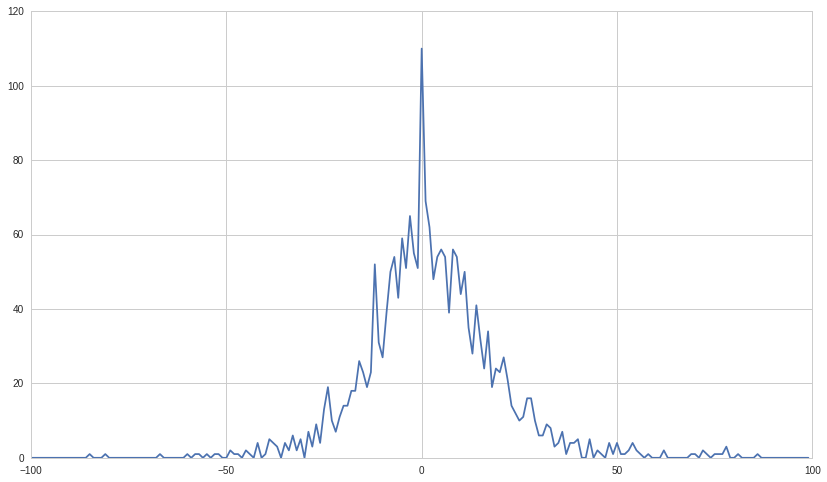

In [166]:
#plt.histogram(res[1],bins=auto)
def x100(x):
    return int(x*100)
def prb_histo(data):
    data = map(x100,data)
    #neghisto = [0]*100
    histo = [0]*200
    for i in range(0,200):
        for n in data:
            if n == i-100:
                histo[i] += 1
    return histo
# y = prb_histo(res)
bulls = []
bears = []
max_score_count = 0
min_score_count = 0
positive_count = 0
negative_count = 0
for s in ratings:
    if s == 1.0:
        max_score_count += 1
    elif s == -1.0:
        min_score_count += 1
    if s > 0:
        bulls += [s]
        positive_count +=1
    else:
        bears += [s]
        negative_count += 1
#print(bulls)
#print(bears)
print(min(res))
print(max(res))
print("bulls median score: "+str(np.median(bulls)))
print("bears median score: "+str(np.median(bears)))
print("total median score: "+str(np.median(res)))
print("1.0 rated equities: "+str(max_score_count))
print("-1.0 rated equities: "+str(min_score_count))
print("positive ratings: "+str(positive_count))
print("negative ratings: "+str(negative_count))
plt.plot(range(-100,100),prb_histo(res))
plt.plot
plt.show()

In [686]:
print(np.mean(bulls))
print(np.mean(bears))
print(np.mean(ratings))
print(" ")
print(ratings.quantile(0.1))
print(ratings.quantile(0.2))
print(ratings.quantile(0.3))
print(ratings.quantile(0.4))
print(ratings.quantile(0.5))
print(ratings.quantile(0.7))
print(ratings.quantile(0.8))
print(ratings.quantile(0.9))

0.147369135304
-0.115271981093
0.0316440869252
 
-0.166420063512
-0.0970252999742
-0.0546256071519
-0.0163812561048
0.0219242024969
0.0992192920727
0.151446159461
0.237180164204


In [45]:
assets = results.index.levels[1].unique()
pricing = get_pricing(assets, start, end + pd.Timedelta(days=90), fields="close_price")

In [ ]:
print(pricing.shape)
print(pricing)

In [ ]:
factor_data = al.utils.get_clean_factor_and_forward_returns(results['ML'], pricing, periods = (20, 65) ,quantiles = 10)#None,bins=[-1,0,0.1,0.2,0.35,0.5,1.1])#10)#, max_loss=100, quantiles=None, bins=[-1.1,0,1.1])
al.tears.create_full_tear_sheet(factor_data)